In [8]:
import os
import glob
import nibabel as nib
import numpy as np
import cv2
import math

import matplotlib.pyplot as plt

In [9]:
data_path = "../data/all/"
os.listdir(data_path)

['VS-239-250',
 '.DS_Store',
 'VS-31-61',
 'VS-176-205',
 'VS-113-143',
 'VS-62-91',
 'README.md',
 'VS-206-238',
 'VS-1-30',
 'VS-144-175',
 'VS-92-112']

In [224]:
seg_list = sorted(glob.glob(os.path.join(data_path, "VS-*-*/vs_*/*_seg_*")))

In [11]:
import plotly.express as px
import json

In [356]:
model_path = "../models/correctionloss_32imgs"
os.listdir(model_path)

['val_history.json',
 'training_files.csv',
 'validation_files.csv',
 'train_history.json',
 'best.pt',
 'checkpoint.pt']

In [357]:
with open(os.path.join(model_path, "train_history.json"), "r") as f:
    train_history = json.load(f)
with open(os.path.join(model_path, "val_history.json"), "r") as f:
    val_history = json.load(f)

In [358]:
fig = px.line({"loss": train_history["loss"], "val_loss": val_history["loss"]})
fig.show()

In [359]:
fig = px.line({"dice": train_history["dice"], "val_dice": val_history["dice"]})
fig.show()

In [360]:
import sys
import re
import csv

sys.path.append("../")
from src.model.correction import CorrectionUnet
from src.data.correction_generator import CorrectionMRIDataset, CorrectionDataLoader
from src.losses.dice import dice_coefficient

import torch

In [361]:
# Load used training files from csv
d = os.path.join(model_path, "training_files.csv")

used_files = []
with open(d) as file:
    training_files = csv.reader(file)
    used_files = [f for f in training_files]
used_files.pop(0)

['seg']

In [362]:
# modify the loaded paths to match the local fs
pattern = r"VS-\d+-\d+/vs_\w+/\w+_seg_\w+\.nii\.gz"
modified_paths = [
    os.path.join(data_path, re.search(pattern, path[0]).group()) for path in used_files
]
modified_paths[:4]

['../data/all/VS-62-91/vs_gk_86/vs_gk_seg_refT2.nii.gz',
 '../data/all/VS-31-61/vs_gk_56/vs_gk_seg_refT2.nii.gz',
 '../data/all/VS-206-238/vs_gk_212/vs_gk_seg_refT2.nii.gz',
 '../data/all/VS-1-30/vs_gk_5/vs_gk_seg_refT2.nii.gz']

In [363]:
if len(modified_paths) > 64:
    modified_paths = modified_paths[:64]

In [364]:
# extract testing files
testing_files = list(set(seg_list) - set(modified_paths))
len(testing_files)

210

In [365]:
data = CorrectionMRIDataset(
    testing_files,
    (256, 256),
    clicks={"num": 3, "dst": 10},
    cuts={
        "num": 12,
        "size": 32,
        "random": False,
    },
    # seed=420
)

In [366]:
model = CorrectionUnet(in_channels=1, out_channels=1, blocks=3).to("mps")

checkpoint = torch.load(os.path.join(model_path, "best.pt"), map_location="mps")
model.load_state_dict(checkpoint["model_state"])

<All keys matched successfully>

In [367]:
len(data)

210

In [368]:
def plot_batched_cuts(pred: torch.Tensor, x, y, cmap="magma"):
    rows = len(pred) // 4
    rows = rows if rows >= 4 else 4
    cols = 3
    res = cols if cols > rows else rows

    # Plot them
    fig, axs = plt.subplots(rows, cols, figsize=(res * 2, res * 2))
    axs = axs.flatten()
    j = 0

    for i in range(pred.shape[0]):
        tmp_cut = torch.clone(pred[i, 0, :, :])
        tmp_cut[pred.shape[2] // 2, pred.shape[2] // 2] = 2
        axs[j].imshow(tmp_cut.cpu(), cmap=cmap)
        axs[j].axis("off")
        axs[j].set_title(
            f"correction dice={dice_coefficient(pred[i].unsqueeze(0), y[i].unsqueeze(0)).item():>5f}",
            fontsize=9,
        )

        tmp_cut = torch.clone(x[i, 0, :, :])
        tmp_cut[pred.shape[2] // 2, pred.shape[2] // 2] = 2
        axs[j + 1].imshow(tmp_cut.cpu(), cmap=cmap)
        axs[j + 1].axis("off")
        axs[j + 1].set_title("training", fontsize=9)

        tmp_cut = torch.clone(y[i, 0, :, :])
        tmp_cut[pred.shape[2] // 2, pred.shape[2] // 2] = 2
        axs[j + 2].imshow(tmp_cut.cpu(), cmap=cmap)
        axs[j + 2].axis("off")
        axs[j + 2].set_title("gt", fontsize=9)

        j += 3
    plt.show()

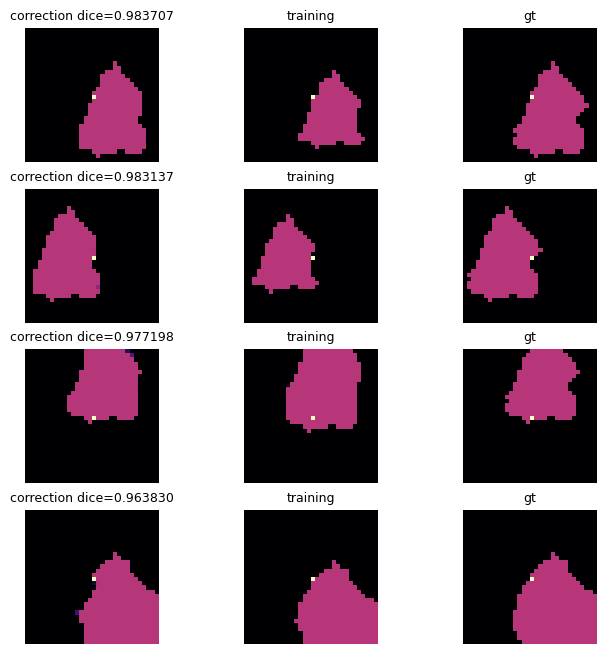

In [388]:
with torch.no_grad():
    dataloader = CorrectionDataLoader(data, 4)
    for i, (x, y) in enumerate(dataloader):
        x, y = x.to("mps"), y.to("mps")
        y_pred = model(x)
        plot_batched_cuts(y_pred, x, y)
        break